In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [5]:
twitch = pd.read_csv('twitchdata-update.csv')
twitch.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,True,False,English
1,summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,True,False,English
2,Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,True,True,Portuguese
3,ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,True,False,English
4,Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,True,False,English


In [7]:
twitch.rename(columns={"Watch time(Minutes)": "WatchTime", "Stream time(minutes)": "StreamTime", "Peak viewers": "PeakViewers", "Average viewers": "AverageViewers",
                            "Followers gained": "FollowersGained", "Views gained": "ViewsGained"}, inplace=True)
twitch.head()

,Channel,WatchTime,StreamTime,PeakViewers,AverageViewers,Followers,FollowersGained,ViewsGained,Partnered,Mature,Language
0,xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,True,False,English
1,summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,True,False,English
2,Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,True,True,Portuguese
3,ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,True,False,English
4,Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,True,False,English


In [9]:
# Check if there is any missing data in the dataframe
missing = twitch.isnull()
missing.head()

,Channel,WatchTime,StreamTime,PeakViewers,AverageViewers,Followers,FollowersGained,ViewsGained,Partnered,Mature,Language
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False


In [10]:
for col in missing.columns.values.tolist():
  print(missing[col].value_counts())
  print("")

False    1000
Name: Channel, dtype: int64

False    1000
Name: WatchTime, dtype: int64

False    1000
Name: StreamTime, dtype: int64

False    1000
Name: PeakViewers, dtype: int64

False    1000
Name: AverageViewers, dtype: int64

False    1000
Name: Followers, dtype: int64

False    1000
Name: FollowersGained, dtype: int64

False    1000
Name: ViewsGained, dtype: int64

False    1000
Name: Partnered, dtype: int64

False    1000
Name: Mature, dtype: int64

False    1000
Name: Language, dtype: int64



## Because of the above check, we can see that there is no missing data and thus no need to clean up any NaN values in the dataframe.

In [11]:
# Check data types to see if we need to change any for use with a linear model
twitch.dtypes

Channel            object
WatchTime           int64
StreamTime          int64
PeakViewers         int64
AverageViewers      int64
Followers           int64
FollowersGained     int64
ViewsGained         int64
Partnered            bool
Mature               bool
Language           object
dtype: object

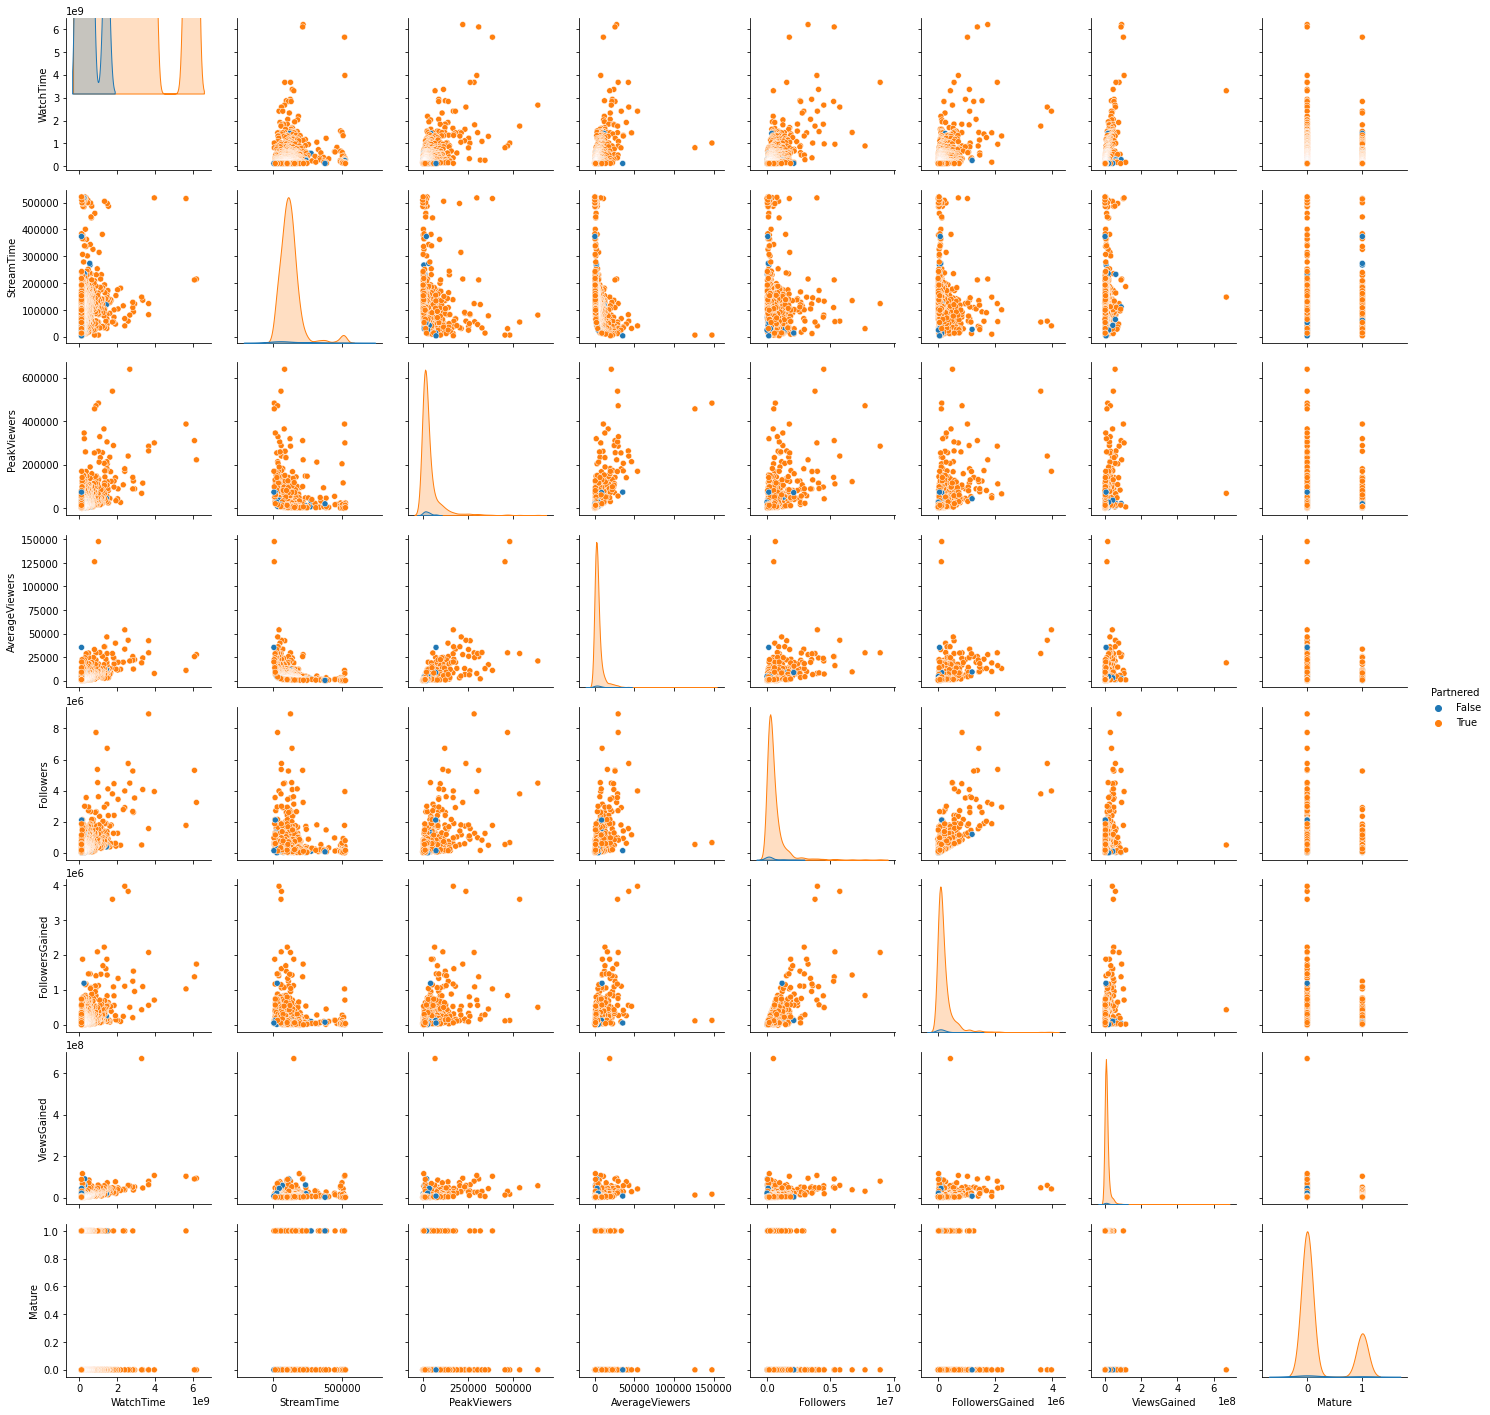

In [12]:
sns.pairplot(twitch, hue='Partnered')

In [13]:
twitch.corr()

,WatchTime,StreamTime,PeakViewers,AverageViewers,Followers,FollowersGained,ViewsGained,Partnered,Mature
WatchTime,1.000000,0.150588,0.582797,0.476165,0.620234,0.514648,0.529862,0.038258,-0.043197
StreamTime,0.150588,1.000000,-0.119540,-0.249248,-0.091299,-0.158165,0.064370,-0.007073,0.044978
PeakViewers,0.582797,-0.119540,1.000000,0.682637,0.532529,0.470415,0.298063,0.028112,-0.082750
AverageViewers,0.476165,-0.249248,0.682637,1.000000,0.428303,0.420097,0.250349,-0.008983,-0.081648
Followers,0.620234,-0.091299,0.532529,0.428303,1.000000,0.715618,0.276467,0.044418,-0.088521
FollowersGained,0.514648,-0.158165,0.470415,0.420097,0.715618,1.000000,0.244297,0.027465,-0.093001
ViewsGained,0.529862,0.064370,0.298063,0.250349,0.276467,0.244297,1.000000,-0.035313,-0.088119
Partnered,0.038258,-0.007073,0.028112,-0.008983,0.044418,0.027465,-0.035313,1.000000,0.000972
Mature,-0.043197,0.044978,-0.082750,-0.081648,-0.088521,-0.093001,-0.088119,0.000972,1.000000


In [17]:
# Parnership seems to have the most positive relation with Followers, so we will create a historgram showing the proportions of followers
bins = np.linspace(min(twitch['Followers']), max(twitch['Followers']), 5)
names = ['low', 'mid-low', 'mid-high', 'high']
twitch['Followers-bins'] = pd.cut(twitch['Followers'], bins, labels=names, include_lowest=True)
twitch[['Followers', 'Followers-bins']].head()

,Followers,Followers-bins
0,3246298,mid-low
1,5310163,mid-high
2,1767635,low
3,3944850,mid-low
4,8938903,high


In [18]:
twitch['Followers-bins'].value_counts()

low         965
mid-low      26
mid-high      6
high          3
Name: Followers-bins, dtype: int64

Text(0.5, 1.0, 'Number of Followers in each Follower Bracket')

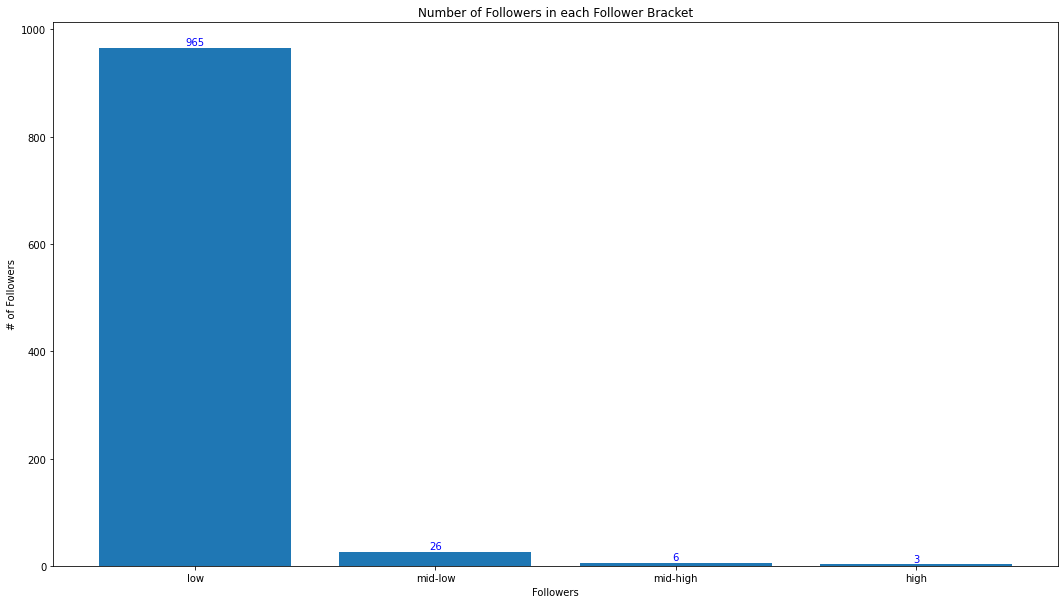

In [27]:
# Plot a bar chart of followers
%matplotlib inline

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i] + 5, y[i], ha = 'center', c='Blue')

plt.figure(figsize=(18,10))
plt.bar(names, twitch['Followers-bins'].value_counts())
addlabels(names, twitch['Followers-bins'].value_counts())
plt.xlabel('Followers')
plt.ylabel('# of Followers')
plt.title('Number of Followers in each Follower Bracket')

In [ ]:
# Continuing with the data analysis, we check the linear relationship between followers and parnership

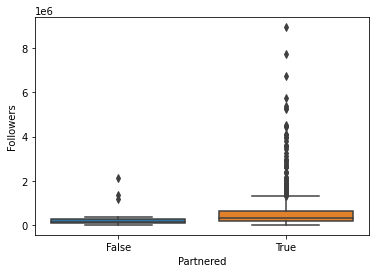

In [29]:
sns.boxplot(x='Partnered', y='Followers', data=twitch)

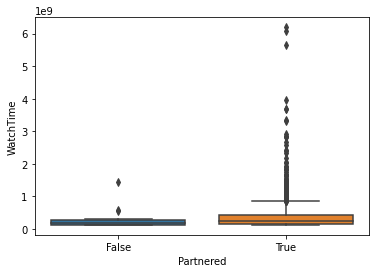

In [30]:
# Watch time also had one of the higher correlations with Partnership
sns.boxplot(x='Partnered', y='WatchTime', data=twitch)

### I will develop two multiple linear models for prediction on the data. One will be trained on the regular set of data while the other will be trained on a standardized version using a pipeline.

In [32]:
# Create a df for the independent variables
X = twitch[['WatchTime', 'StreamTime', 'PeakViewers', 'AverageViewers', 'Followers', 'FollowersGained', 'ViewsGained', 'Mature']]
X['Mature'] = X['Mature'].astype('int') # Change boolean value to integer for use with linear regression model
X.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,WatchTime,StreamTime,PeakViewers,AverageViewers,Followers,FollowersGained,ViewsGained,Mature
0,6196161750,215250,222720,27716,3246298,1734810,93036735,0
1,6091677300,211845,310998,25610,5310163,1370184,89705964,0
2,5644590915,515280,387315,10976,1767635,1023779,102611607,1
3,3970318140,517740,300575,7714,3944850,703986,106546942,0
4,3671000070,123660,285644,29602,8938903,2068424,78998587,0


In [34]:
# Set target variable
Y = twitch['Partnered'].astype('int')
Y.value_counts()

1    978
0     22
Name: Partnered, dtype: int64

### We come across a problem here as the proportion of partnered vs non-partnered streamers is largely skewed towards partnership in this data set. This will affect the prediction of our linear model so in order to correct for this, we will attempt to upsample the minority class using SMOTE.


In [109]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X,Y)
y_ser = pd.Series(y_res)
y_ser.value_counts()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1    978
0    978
dtype: int64

In [111]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_ser, test_size=0.3, random_state=5)

In [112]:
# Create first model for use without normalization
lm1 = LogisticRegression()
lm1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [113]:
# print coefficients and intercepts
print("The coefficients of our first linear model are:", lm1.coef_, ", and the intercept is:", lm1.intercept_)

The coefficients of our first linear model are: [[ 3.27172690e-09 -1.86827248e-06  1.42152157e-07 -2.97932047e-07
   2.34499632e-07 -4.56127430e-07 -6.15706221e-08  1.61007515e-11]] , and the intercept is: [-8.40076247e-12]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


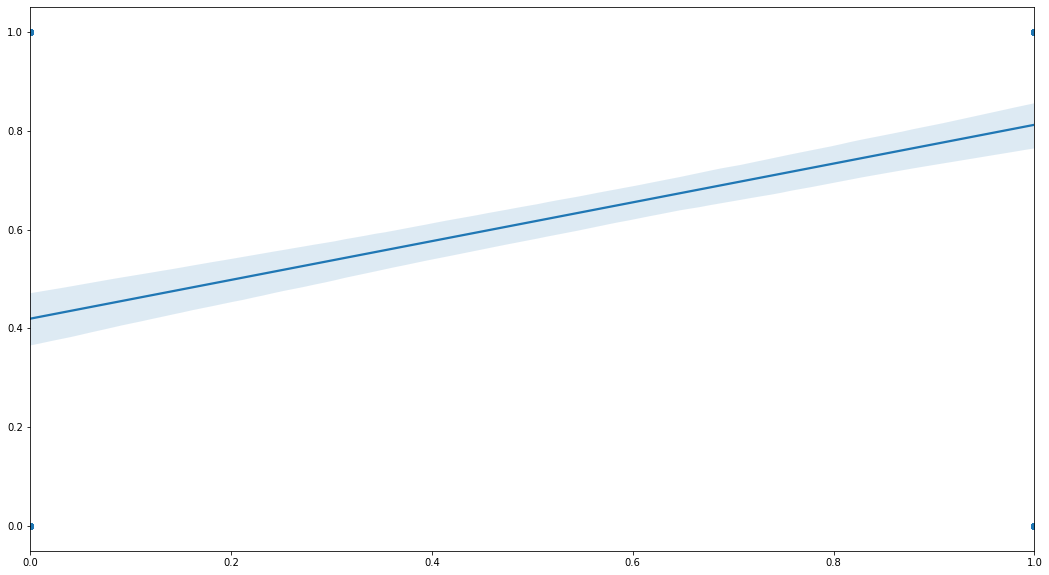

In [74]:
# Test our set of predictions on the test data and create a plot to compare the actual vs the test
predictions = lm1.predict(X_test)
plt.figure(figsize=(18,10))
sns.regplot(y_test, predictions)

In [75]:
predictions

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


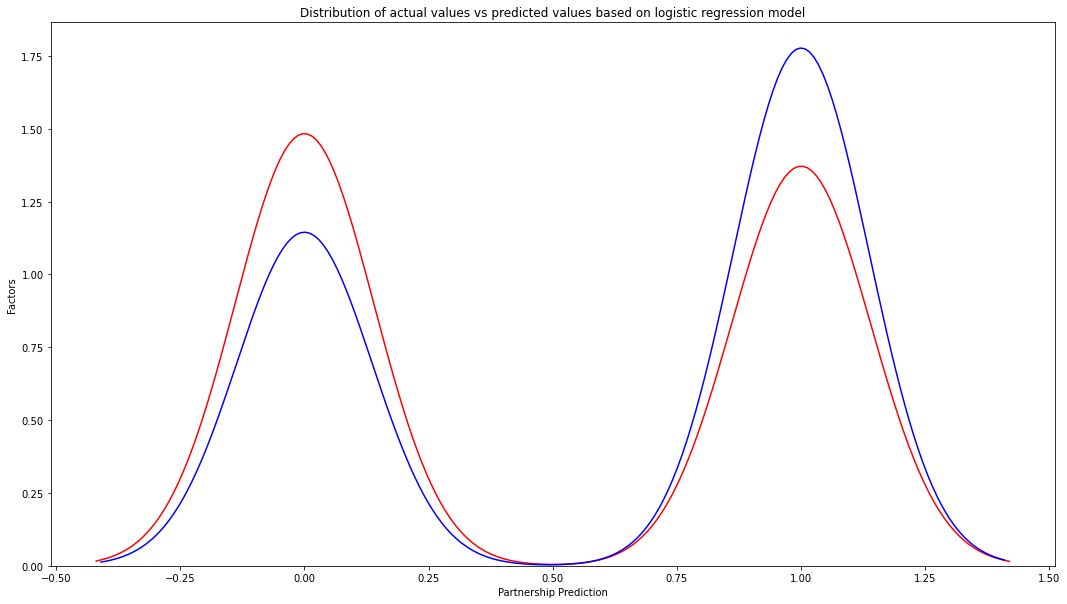

In [77]:
# Let's try a distribution plot as well
plt.figure(figsize=(18,10))

ax1 = sns.distplot(y_test, hist=False, color='Red', label='Actual Test Values')
sns.distplot(predictions, hist=False, color='Blue', label='Predicted values', ax=ax1)

plt.title("Distribution of actual values vs predicted values based on logistic regression model")
plt.xlabel("Partnership Prediction")
plt.ylabel("Factors")

plt.show()

Text(0.5, 69.0, 'Predicted label')

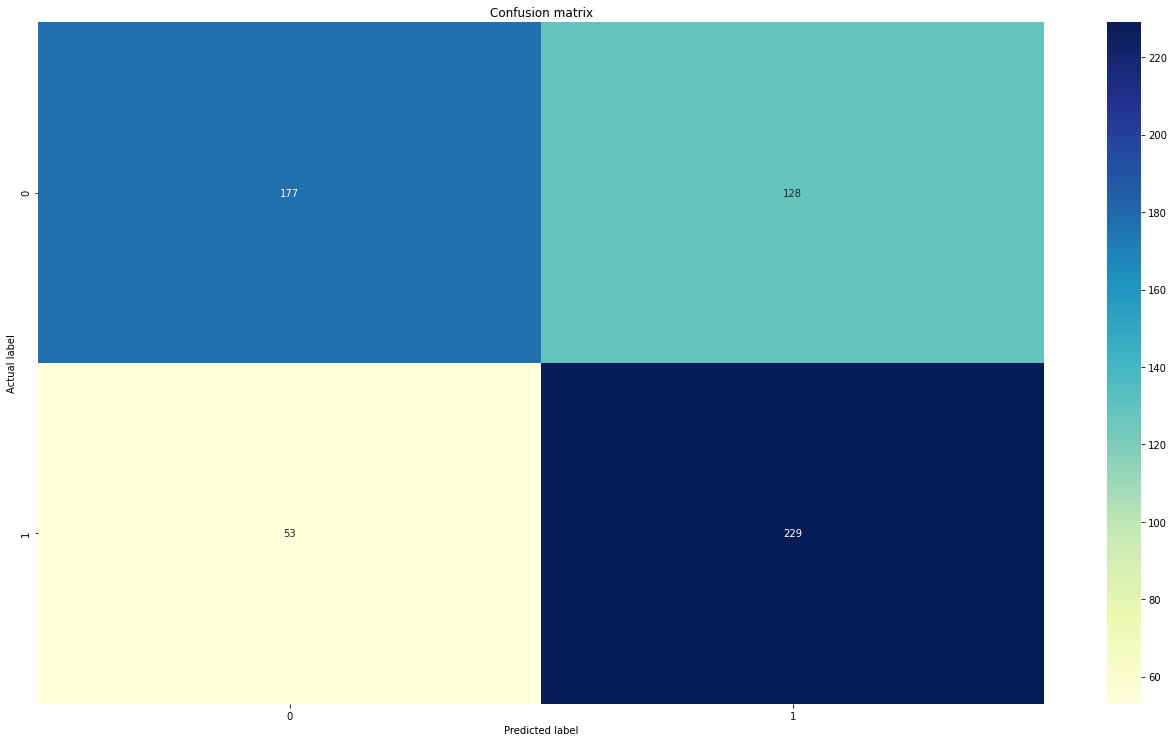

In [89]:
# To test evaluate the model, we will visualize a confusion matrix

cf_mat = metrics.confusion_matrix(y_test, predictions)

c_names = ['Partnered', 'Not Partnered']
plt.figure(figsize=(18,10))

ticks = np.arange(len(c_names))
plt.xticks(ticks, c_names)
plt.yticks(ticks, c_names)
# create heatmap to visualize confusion matrix
sns.heatmap(pd.DataFrame(cf_mat), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [93]:
# We can also use the metrics library to figure out the accuracy, precision, and recall of the model
print("Accuracy:",round(metrics.accuracy_score(y_test, predictions)* 100,2),"%")
print("Precision:",round(metrics.precision_score(y_test, predictions)* 100,2),"%")
print("Recall:",round(metrics.recall_score(y_test, predictions)* 100,2),"%")

Accuracy: 69.17 %
Precision: 64.15 %
Recall: 81.21 %


### We can also create another model after normalizing all the feature values. Here I am using a pipeline to simplify the process.

In [84]:
# Here we Create the second model using a pipeline
Input=[('scale', StandardScaler()), ('model', LogisticRegression())]

pipe = Pipeline(Input)

pipe.fit(X_train, y_train)

y_hat = pipe.predict(X_test)
y_hat

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,

Text(0.5, 69.0, 'Predicted label')

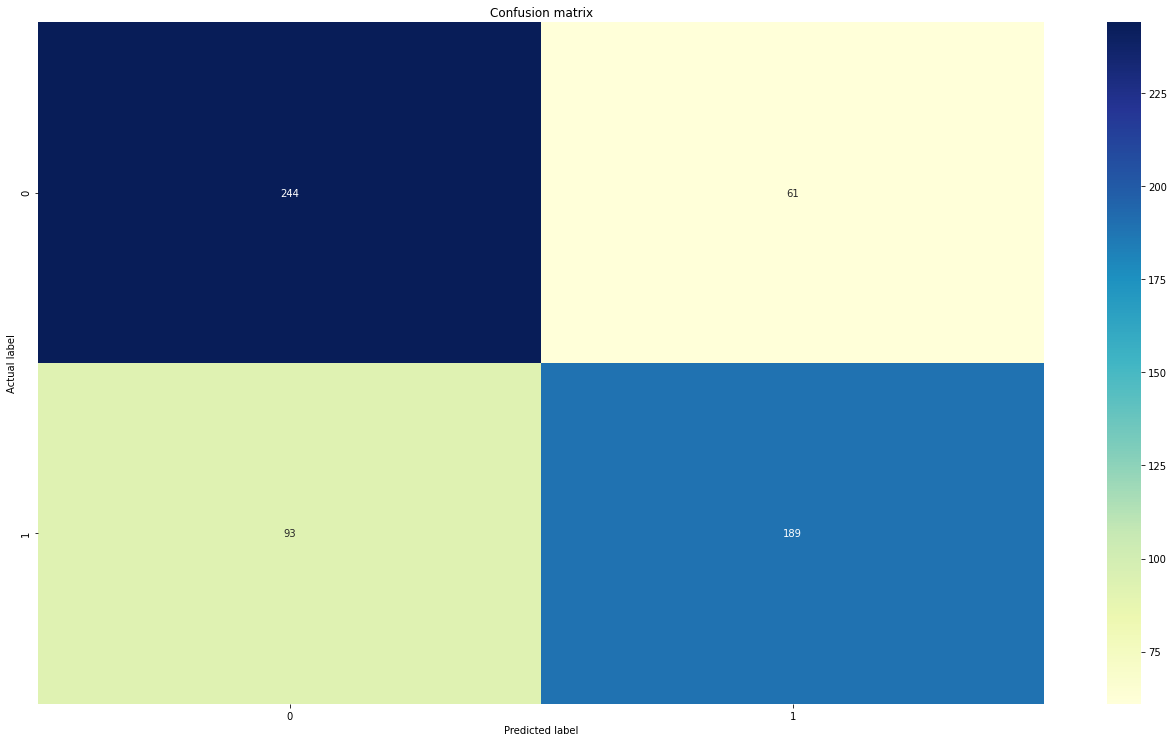

In [94]:
# We can repeat the evaluation step using the confusion matrix visualization and the accuracy, precision, and recall scores
# To test evaluate the model, we will visualize a confusion matrix

cf_mat2 = metrics.confusion_matrix(y_test, y_hat)

plt.figure(figsize=(18,10))

ticks = np.arange(len(c_names))
plt.xticks(ticks, c_names)
plt.yticks(ticks, c_names)
# create heatmap to visualize confusion matrix
sns.heatmap(pd.DataFrame(cf_mat2), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [96]:
# We can also use the metrics library to figure out the accuracy, precision, and recall of the model
print("Accuracy:",round(metrics.accuracy_score(y_test, y_hat)* 100,2),"%")
print("Precision:",round(metrics.precision_score(y_test, y_hat)* 100,2),"%")
print("Recall:",round(metrics.recall_score(y_test, y_hat)* 100,2),"%")

Accuracy: 73.76 %
Precision: 75.6 %
Recall: 67.02 %


## We can see by comparison, the accuracy and precision of the second model is higher than that of the first, but the recall is much higher on the first model than the second. Based on this information, we could utilize one model over the other depending on what business problem we would need to answer with the data at hand.

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00000


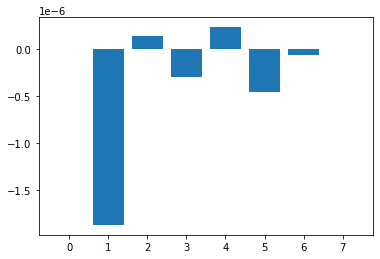

In [114]:
# One more interesting thing we can do is check for feature importance within the model
# get importance
importance = lm1.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()